# 实验四：利用torch.nn实现卷积神经网络AlexNet
姓名：王恩泰

学号：21114019

In [1]:
import os
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.utils.data as Data
import torch.nn.functional as F
import torch.nn as nn
from PIL import Image

## 1. 读取数据集

In [2]:
file_dir = ['./车辆分类数据集/car', './车辆分类数据集/bus', './车辆分类数据集/truck']

num_of_class = 3
batch_size = 8
device = torch.device("cpu")

transform_compose = transforms.Compose( # 串联多个transform操作
    [transforms.Resize([227, 227]),  # 统一图形尺寸
     transforms.ToTensor(), # 转成tensor,ToTensor()能够把灰度范围从0-255变换到0-1之间
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # RGB 3个0.5,transform.Normalize()则把0-1变换到(-1,1), image=(image-mean)/std
])

train_tensor = None
test_tensor = None
train_label = []
test_label = []

# 逐个图片处理
for _dix, _dir in enumerate(file_dir):
    files = os.listdir(_dir) # 获取file list
    number_of_img = len(files) # img数量
    for index, img_file in enumerate(files):
        if img_file.endswith('.jpg'):
            img = Image.open(_dir+'/'+img_file)
            img = img.resize((227,227), Image.ANTIALIAS) # 变形
            # 对于AlexNet, 图片必须改成227*227尺寸
            img = np.array(img)/255
            img_tensor = torch.from_numpy(img)
            img_tensor = img_tensor.permute(2,1,0) # what means?
            if index < (0.8*number_of_img):
                if train_tensor is None:
                    print(img_tensor.shape)
                    train_tensor = img_tensor.unsqueeze(0)
                    print(train_tensor.shape)
                else:
                    train_tensor = torch.cat((train_tensor, img_tensor.unsqueeze(0)), dim=0)
                train_label.append(_dix)
            else:
                if test_tensor is None:
                    test_tensor = img_tensor.unsqueeze(0)
                else:
                    test_tensor = torch.cat((test_tensor, img_tensor.unsqueeze(0)), dim=0)
                test_label.append(_dix)

train_dataset = Data.TensorDataset(train_tensor, torch.LongTensor(train_label)) # train tensor 和 label tensor组合
test_dataset = Data.TensorDataset(test_tensor, torch.LongTensor(test_label))
train_data_loader = Data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
test_data_loader = Data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False)

# 这个dataloader同时存了X和y
print(train_tensor.shape)
print(test_tensor.shape) # (数量, 通道, H, W)

torch.Size([3, 227, 227])
torch.Size([1, 3, 227, 227])
torch.Size([1088, 3, 227, 227])
torch.Size([269, 3, 227, 227])


## 2. 利用torch.nn定义AlexNet
 ![title](AlexNet.jpg)

In [3]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2), # padding数目根据same peddling计算
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1), # padding数目根据same peddling计算
            nn.ReLU(inplace=True)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1), # padding数目根据same peddling计算
            nn.ReLU(inplace=True)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1), # padding数目根据same peddling计算
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.layer6 = nn.Sequential(
            nn.Linear(in_features=6*6*256, out_features=4096), # 6*6*256看图
            nn.ReLU(inplace=True),
            nn.Dropout()
        )
        self.layer7 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=1024), # 6*6*256看图
            nn.ReLU(inplace=True),
            nn.Dropout()
        )
        self.layer8 = nn.Linear(in_features=1024, out_features=3) # 一共三类车
    
    def forward(self, x):
        # layer 1 ~ layer 5
        x = self.layer5(self.layer4(self.layer3(self.layer2(self.layer1(x)))))
        x = x.view(-1, 6*6*256)
        x = self.layer8(self.layer7(self.layer6(x)))
        x = F.softmax(x, dim=1)
        return x

## 3. 初始化参数
(因为class AlexNet所有参数是直接给出的，并不在__init__构造函数中，所以要另写函数初始化参数???)

In [4]:
def init_params(model): # 这个model传参在哪里用？
    if isinstance(model, nn.Linear): # 对于线性层的初始化参数
        nn.init.normal_(model.weight, 1) 
        nn.init.constant_(model.bias, 0)
    elif isinstance(model, nn.Conv2d): # 对于卷积层的初始化参数
        nn.init.normal_(model.weight)
    elif isinstance(model, nn.BatchNorm2d): # 对于归一化层的初始化参数 
        nn.init.normal_(model.weight, 1) 
        nn.init.constant_(model.bias, 0)

## 5. 训练及测试

In [5]:
def train_epoch(net, data_loader, device): # 一个epoch的程序
    net.train() # 训练模式
    train_batch_num = len(data_loader)
    total_loss = 0
    correct = 0 # 正确分类样本个数
    sample_num = 0 # 样本总数

    for batch_idx, (x_train, y_train) in enumerate(data_loader):
        x_train = x_train.to(device).float()
        y_train = y_train.to(device).long() # 因为预测出来是long的
        
        optimizer.zero_grad()
        y_predict = net(x_train)
        # print(y_train)
        # print(y_predict)
        loss = criterion(y_predict, y_train)
        loss.backward()
        optimizer.step() # 更新参数

        total_loss += loss.item()
        prediction = torch.argmax(y_predict, 1)
        correct += (prediction == y_train).sum().item()
        sample_num += len(prediction)
    loss = total_loss / len(train_dataset)
    acc = correct / len(train_dataset)
    return loss, acc

def test_epoch(net, data_loader, device):
    net.eval()
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    with torch.no_grad():
        for batch_idx, (x_test, y_test) in enumerate(data_loader):
            x_test = x_test.to(device).float()
            y_test = y_test.to(device).long()
            y_predict = net(x_test)
            loss = criterion(y_predict, y_test)

            total_loss += loss.item()
            prediction = torch.argmax(y_predict, 1)
            correct += (prediction == y_test).sum().item()
            sample_num += len(prediction)
    loss = total_loss / len(test_dataset)
    acc = correct / len(test_dataset)
    return loss, acc

## 6. 主函数

AlexNet(
  (layer1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (layer4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (layer5): Sequential(
    (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer6): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    

D:\Anaconda\envs\pytorch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch: 0	 train_loss: 0.1596 	train_acc: 0.2748 	test_loss: 0.1624	 test_acc: 0.2677
epoch: 1	 train_loss: 0.1598 	train_acc: 0.2730 	test_loss: 0.1621	 test_acc: 0.2677
epoch: 2	 train_loss: 0.1597 	train_acc: 0.2739 	test_loss: 0.1626	 test_acc: 0.2677
epoch: 3	 train_loss: 0.1600 	train_acc: 0.2711 	test_loss: 0.1624	 test_acc: 0.2677
epoch: 4	 train_loss: 0.1590 	train_acc: 0.2794 	test_loss: 0.1621	 test_acc: 0.2677
epoch: 5	 train_loss: 0.1602 	train_acc: 0.2702 	test_loss: 0.1624	 test_acc: 0.2677
epoch: 6	 train_loss: 0.1591 	train_acc: 0.2785 	test_loss: 0.1626	 test_acc: 0.2677
epoch: 7	 train_loss: 0.1566 	train_acc: 0.2987 	test_loss: 0.1621	 test_acc: 0.2677
epoch: 8	 train_loss: 0.1571 	train_acc: 0.2950 	test_loss: 0.1621	 test_acc: 0.2677
epoch: 9	 train_loss: 0.1597 	train_acc: 0.2739 	test_loss: 0.1626	 test_acc: 0.2677
epoch: 10	 train_loss: 0.1596 	train_acc: 0.2748 	test_loss: 0.1621	 test_acc: 0.2677
epoch: 11	 train_loss: 0.1592 	train_acc: 0.2776 	test_loss: 0.1

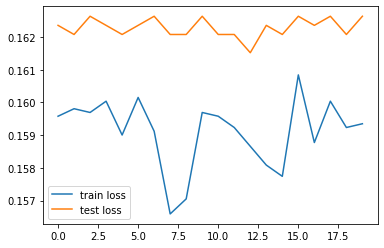

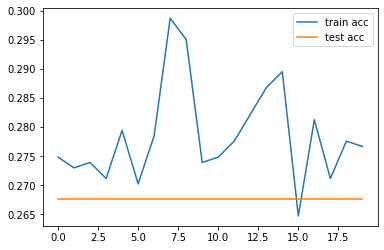

In [6]:
epochs = 20
lr = 0.001
# batch_size = 128
device = torch.device("cpu")

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

# 声明Alexnet model
net = AlexNet().to(device)
net.apply(init_params) # apply函数的含义？
print(net)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(net, train_data_loader, device)
    test_loss, test_acc = test_epoch(net, test_data_loader, device)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    print(f"epoch: {epoch}\t train_loss: {train_loss:.4f} \t" f"train_acc: {train_acc:.4f} \t"
         f"test_loss: {test_loss:.4f}\t test_acc: {test_acc:.4f}")        


plt.plot(train_loss_list, label='train loss')
plt.plot(test_loss_list, label='test loss')
plt.legend() 
plt.show()     
plt.plot(train_acc_list, label='train acc')
plt.plot(test_acc_list, label='test acc')
plt.legend() 
plt.show()    